# Lecture 3 - Bayesian Statistics in Action: The Beta-Binomial Model

## Today's Learning Objectives

1. Illustrate the elements and process of Bayesian modelling.
2. Recall some distributional probability concepts.
4. Explain the Bayes' rule on analytical models. 
3. Describe the Beta-Binomial model via the Bayes' rule.
4. Explain key posterior metrics for Bayesian inference.

## Loading `R` Packages

In [1]:
options(repr.matrix.max.rows = 6)
library(bayesrules)
library(ggplot2)
library(cowplot)
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1


── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ lubridate::stamp() masks cowplot::stamp()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Previously...

We have discussed the difference between frequentist and Bayesian statistics. One of the most critical characteristics of Bayesian thinking is that **population parameters are not fixed anymore but RANDOM**. Furthermore, we demonstrate the Bayes' rule's usefulness (via probability theory!).

Note the Bayes' rule has solid foundations on conditional probability. However, we have only seen cases with categorical outcomes (e.g., the binary Tinder case). 

```{important}
Bayes' rule can also be applied to continuous variables combined with discrete ones.
```

## 1. The Bayesian Modelling

Note the big advantage of Bayesian inference: **it formulates every statistical inference problem in one common framework** (as we will see in `lab2`!). Moreover, the final goal will be to take samples from the posterior distribution. 

```{tip}
Besides [`Stan`](https://mc-stan.org/), there are some other good simulation tools such as [`JAGS`](http://mcmc-jags.sourceforge.net/) and [Tensorflow Probability](https://www.tensorflow.org/probability).
```

**No matter what your model is, your computer will do the heavy lifting!** We will get to spend all our mental effort on **good model design** and **critical analysis of results**.

Bayesian modelling has the following characteristics:

- It is a very intuitive description of **uncertainty before/after seeing data**.
- It provides **valid inference for any (finite) amount of data**. 
- Furthermore, it allows using **more complex/flexible/realistic models**!

### 1.1. The Big Idea

Bayesian modelling involves these steps:

1. **Question:** Pose a scientific question.
2. **Design:** Formulate variables and create a probabilistic model for them. **Prior knowledge** is included here!
3. **Infer:** Get **posterior samples** from the conditional distribution of **any variable you want to infer**, given your observed data and prior knowledge.
4. **Check:** Make sure the "samples" are *actually* from your posterior (these are model diagnostics, **to be covered in week 4**!) 
5. **Analyze:** Use your samples to compute summaries: mean, maximum a posteriori (MAP), variance, posterior credible intervals (**to be explained today**), etc.

### 1.2. Pose a Question

There are many different models / hypothetical latent parameters for the same data. To design a good model, **your whole design process should revolve around one/more scientific question(s)**.

Let us recall the two fundamental statistical purposes, which also apply for Bayesian modelling.

**Inferential:** Using observed data $Y$ to infer latent variable $\theta$. For example:
- **Bottlecap experiment:** what is the underlying flip probability $\pi \in [0, 1]$?
- **$\text{CO}_2$ emissions:** in regression analysis, what is the slope $\beta_1\in\mathbb{R}$ of $\text{CO}_2$ over time?

**Predictive:** Using observed data $Y$ to predict future data $Y'$.

- **Bottlecap experiment:** what is probability that the *next* toss $Y'\in\{0, 1\}$ will be right side up? 
- **$\text{CO}_2$ emissions:** what will the $\text{CO}_2$ concentration $Y'\in\mathbb{R}$ be in 2030?

Let us check an example, the bikeshare data.

- **Description:** Hourly record of the number of bike trips in Washington, DC in 2011/2012.
- **Source:** [2011/12 Capital Bikeshare Data](https://www.kaggle.com/marklvl/bike-sharing-dataset).
- **Variables:**  date, hour, holiday/weekend/workday, weather, temperature, number of trips.

```{exercise}
:label: lecture3-q1

Assume we only care about what happened in 2011/12 in Washington, DC. Then, using the bikeshare data, suppose we want to check which type of trip is the most popular: *holiday*, *workday*, or *weekend trips*.

What class of inquiry is this?

**A.** Inferential.

**B.** Predictive.

**C.** Neither.
```

```{exercise}
:label: lecture3-q2

Using the bikeshare data, suppose we want to determine how temperature/weather is associated with the number of trips.

What class of inquiry is this?

**A.** Inferential.

**B.** Predictive.

**C.** Neither.
```

```{exercise}
:label: lecture3-q3
Using the bikeshare data, suppose we want to determine how many trips will be taken on a day that is 25C and misty.

What class of inquiry is this?

**A.** Inferential.

**B.** Predictive.

**C.** Neither.
```

(basic-distributional-concepts)=
## 2. Basic Distributional Probability Concepts

Before checking formal Bayesian inference, it is necessary to review basic distributional probability concepts from **DSCI 551**. Specifically speaking, let $Z$ be a continuous random variable. Furthermore, $f_Z(z)$ is its probability density function (PDF). Hence, to consider $f_Z(z)$ a proper PDF, it needs the following properties:

- $f_Z(z) \geq 0.$
- $\int_{z} f_Z(z) \,dz = 1$ (the area under the PDF is equal to 1, i.e., **the total probability**).
- $P(u < Z < v) = \int_{u}^v f_Z(z) \,dz$ when $u \leq v$ (the probability of $Z$ being between $u$ and $v$ is obtained by integrating the PDF to get the corresponding area under the curve).

## 3. The Beta-Binomial Model

The Beta-Binomial model is one of the foundational Bayesian models.

```{attention}
The Beta-Binomial model in Bayesian statistics can be solved **analytically** to obtain the exact posterior distribution of our parameter of interest, i.e., using Markov Chain Monte Carlo (MCMC) to get an approximate posterior distribution is unnecessary **in practice**. **Nevertheless, we will do it in `lab2` to verify that MCMC actually works.**

The literature also offers other classes of analytical Bayesian models that can be solved via the Bayes' rules such as Gamma-Poisson (**to be covered in `worksheet2`**).
```

We will use two common distributions: [**Beta**](beta-distribution) and [**Binomial**](binomial-distribution). Each distribution will play a crucial role in this inferential process (**via the Bayes' rule!**). Keep this in mind for the Beta-Binomial model:

$$\text{posterior} \propto \text{prior} \times \text{likelihood}.$$

Thus, in this framework, we need to define the specific **prior** and **likelihood** to get the **posterior** of our population parameter of interest.

Let us continue with the bottle cap flip example.

<br>
<center><img width="400" src="https://img1.cgtrader.com/items/730507/8a23f572f4/plastic-pet-bottle-cap-3d-model-obj-mtl-fbx-stl-blend.png"/></center>

```{admonition} Main statistical inquiry
Recall the inferential problem: **what is the probability $\pi$ the bottle cap will land right side up?** We already approached this problem using a frequentist approach.

**So, how can we do it the Bayesian way?** Again, $\pi$ is our population parameter of interest.
```

### 3.1. Starting with a Bernoulli Distribution

A **single** bottle cap flip $X_i$ is assumed as:

$$X_i \sim \mathrm{Bernoulli}(\pi) \quad \text{for} \quad i = 1, \dots, n.$$

- $\pi \in [0, 1]$ is the unknown parameter we want to infer: **the probability the bottle cap will land right side up**.
- $X_i$ are the results of each bottle cap toss ($1 = \text{right side up}$ or $0 = \text{upside down}$).
- $X_i = 1$ is the success with probability $\pi$.

Moreover, **what is the role of of the of the number of trials $n$ in this framework?** This $n$ will pave the way to the Binomial distribution.

### 3.2. The Binomial Distribution

Suppose you run a study and execute $n$ **independent** flips to make inference on $\pi$ (i.e., $n$ Bernoulli trials). At the end of the study, you count the number of successes (i.e., number of times the bottle cap landed right side up). **This a sum of successes within $n$ Bernoulli trials!** Define this sum as:

$$Y = \sum_{i = 1}^n X_i.$$

```{important}
A sum of random variables will also be a random variable!
```

We might wonder, **does $Y$ have a known distribution?** Using [this resource](http://www.math.wm.edu/~leemis/chart/UDR/UDR.html), we encounter the following:

```{figure} ../img/binomial_bernoulli.png
:height: 120px
:name: binomial_bernoulli
```

*Source: [Univariate Distribution Relationships](http://www.math.wm.edu/~leemis/chart/UDR/UDR.html)*

```{attention}
In the above image, term $p$ refers to our $\pi$.
```

It can be proved (**not within the scope of this course**) that:

$$Y \sim \text{Binomial}(n , \pi) \quad \text{where} \quad \pi \in [0, 1].$$

Hence, the sum of $n$ **independent and identically distributed (iid) Bernoulli** random variables (with parameter $\pi$) is a **Binomial** (with parameters $n$ and $\pi$).

### 3.3. The Beta Distribution

Moving along with this bottle cap study, note we have the following:

$$Y \mid \pi \sim \text{Binomial}(n, \pi) \quad \text{where} \quad \pi \in [0, 1].$$

```{attention}
**What is this expression telling us?** This expression is **conditioning** $Y$ on $\pi$. Therefore, here comes the Bayesian twist:

> One of the most critical characteristics of Bayesian thinking is that **population parameters are not fixed anymore but RANDOM**.
```

We will begin with our model design! The first step is to find a **prior** distribution for $\pi \in [0,1]$ (our parameter of interest). Note that $\pi$ is a probability, thus we need to find a distribution with the **right support** (i.e., a proper range of plausible values).

$\pi$ is a probability taking on values between 0 and 1. A suitable choice for the **continuous** prior distribution of $\pi$ is the [**Beta distribution**](beta-distribution). Hence, the prior distribution is: 

$$\pi \sim \text{Beta}(a, b).$$

Its PDF is:

$$f(\pi) = \frac{\Gamma(a + b)}{\Gamma(a) \Gamma(b)} \pi^{a - 1} (1 - \pi)^{b - 1} \quad \text{for} \quad 0 \leq \pi \leq 1,$$

where $\Gamma(\cdot)$ is the so-called Gamma function. Moreover, the **shape** parameters $a > 0$ and $b$ are called **hyperparameters**.

```{caution}
The [**Beta PDF in the cheatsheet**](beta-distribution) has $x$ as a variable instead of $\pi$. Moreover, shape parameters $a > 0$ and $b > 0$ are renamed as $\alpha$ and $\beta$ respectively.
```

```{attention}
You will not need to do any Calculus-related computation in this Bayesian analysis. Note that this Beta prior is a **probability distribution over probabilities**. This idea can take time to sink in.
```

Recall that the Beta distribution will be our prior belief on the parameter of interest $\pi$ (**the probability the bottle cap will land right side up**). The hyperparameters $a$ and $b$ will tune our Beta prior to picture these beliefs.

We will use this interactive [Shiny app](https://shiny-apps.stat.ubc.ca/FlexibleLearning/FirstBayes/Beta-Binomial/) (attribution to [Gian Carlo Diluvi](https://giankdiluvi.github.io/) from the Department of Statistics at UBC). **In this app, parameter $p$ refers to $\pi$.**

Let us focus on the Shiny app's section `Prior Distribution`. On the left-hand side bar, you can tune the hyperparameters $a$ and $b$. Furthermore, regarding your prior beliefs for $\pi$, suppose you are interested in four different scenarios:

1. $\text{Beta}(a = 3, b = 7).$
2. $\text{Beta}(a = 1, b = 1).$
3. $\text{Beta}(a = 10, b = 10).$
4. $\text{Beta}(a = 7, b = 3).$

Let us also plot these four scenarios to compare them altogether:

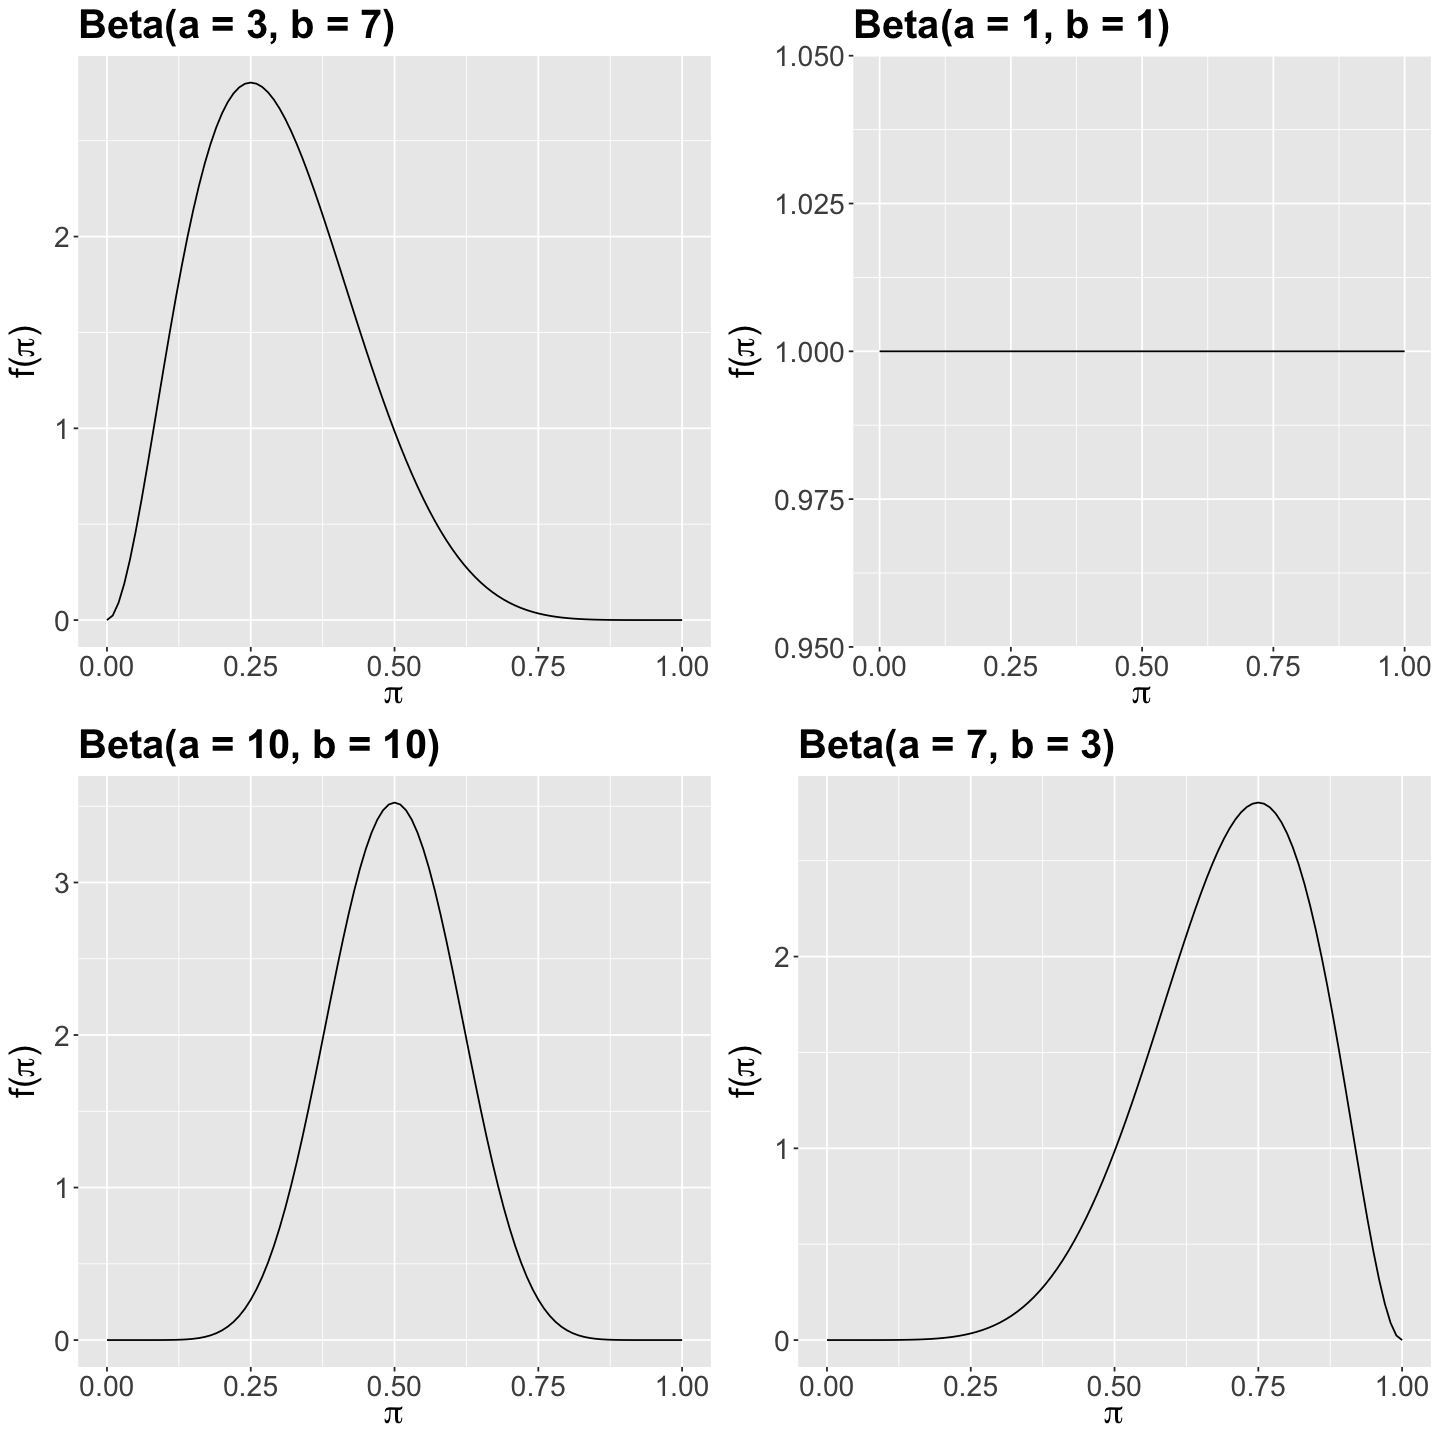

In [2]:
options(repr.plot.height = 12, repr.plot.width = 12)

# Plotting the four different Beta priors on pi

beta_3_7 <- plot_beta(3, 7) +
  labs(y = expression(paste("f(", pi, ")")), x = expression(paste(pi))) +
  ggtitle("Beta(a = 3, b = 7)") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text.x = element_text(size = 17, angle = 0),
    axis.text.y = element_text(size = 17, angle = 0),
    axis.title = element_text(size = 21)
  )

beta_1_1 <- plot_beta(1, 1) +
  labs(y = expression(paste("f(", pi, ")")), x = expression(paste(pi))) +
  ggtitle("Beta(a = 1, b = 1)") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text.x = element_text(size = 17, angle = 0),
    axis.text.y = element_text(size = 17, angle = 0),
    axis.title = element_text(size = 21)
  )

beta_10_10 <- plot_beta(10, 10) +
  labs(y = expression(paste("f(", pi, ")")), x = expression(paste(pi))) +
  ggtitle("Beta(a = 10, b = 10)") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text.x = element_text(size = 17, angle = 0),
    axis.text.y = element_text(size = 17, angle = 0),
    axis.title = element_text(size = 21)
  )

beta_7_3 <- plot_beta(7, 3) +
  labs(y = expression(paste("f(", pi, ")")), x = expression(paste(pi))) +
  ggtitle("Beta(a = 7, b = 3)") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text.x = element_text(size = 17, angle = 0),
    axis.text.y = element_text(size = 17, angle = 0),
    axis.title = element_text(size = 21)
  )

plot_grid(beta_3_7, beta_1_1, beta_10_10, beta_7_3)

```{exercise}
:label: lecture3-q4

How would you graphically describe the prior behaviour of $\pi$ in the above four scenarios?
```

The [Shiny app](https://shiny-apps.stat.ubc.ca/FlexibleLearning/FirstBayes/Beta-Binomial/) also provides the corresponding **mean** and **variance** (*bottom left-hand corner*) for each specific Beta case (i.e., for specific values of $a$ and $b$). Theoretically, it can be shown that the mean $\mathbb{E}(\pi)$ and variance $\text{Var}(\pi)$ are:

$$\mathbb{E}(\pi) = \frac{a}{a + b} \quad \text{and} \quad \text{Var}(\pi) = \frac{ab}{(a + b)^2(a + b + 1)}.$$

The standard deviation is merely 

$$\text{sd}(\pi) = \sqrt{\text{Var}(\pi)}.$$

Moreover, the mode is:

$$\text{Mode}(\pi) = \frac{a - 1}{a + b - 2} \quad \text{when} \quad a,b > 1.$$

```{important}
Keep in mind these **PRIOR** metrics!
```

### 3.4. Choosing the Beta Prior

**How to select a suitable Beta prior for our parameter of interest $\pi$?** This is where we have to rely on the subject-matter prior knowledge. 

For example, suppose we collect information from 30 previous studies, similar to ours, in which the **estimated proportions** of successes are contained in `prior_pi_studies` (**this is simulated prior data**).

In [3]:
prior_pi_studies <- read_csv("../data/prior_pi_studies.csv", show_col_types = FALSE)
prior_pi_studies

prior_pi
<dbl>
0.6796351
0.5198155
0.7373692
⋮
0.5737930
0.5391176
0.7321295


Now, we obtain a histogram of `prior_pi_studies` (with the adjusted $y$-axis as `after_stat(density)`). 

In [4]:
options(repr.plot.height = 9, repr.plot.width = 12)

# Plottiong density of prior_pi_studies overlapped with a Beta(a = 7, b = 3)
beta_7_3 <- beta_7_3 +
  geom_histogram(
    data = prior_pi_studies,
    aes(x = prior_pi, y = after_stat(density)), fill = "grey", color = "blue", bins = 20, alpha = 0.3
  ) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21)
  ) +
  labs(y = expression(paste("f(", pi, ")")), x = expression(paste(pi)))

We can see that `prior_pi_studies` is left-skewed suggesting a possible prior $\text{Beta}(a = 7, b = 3)$.

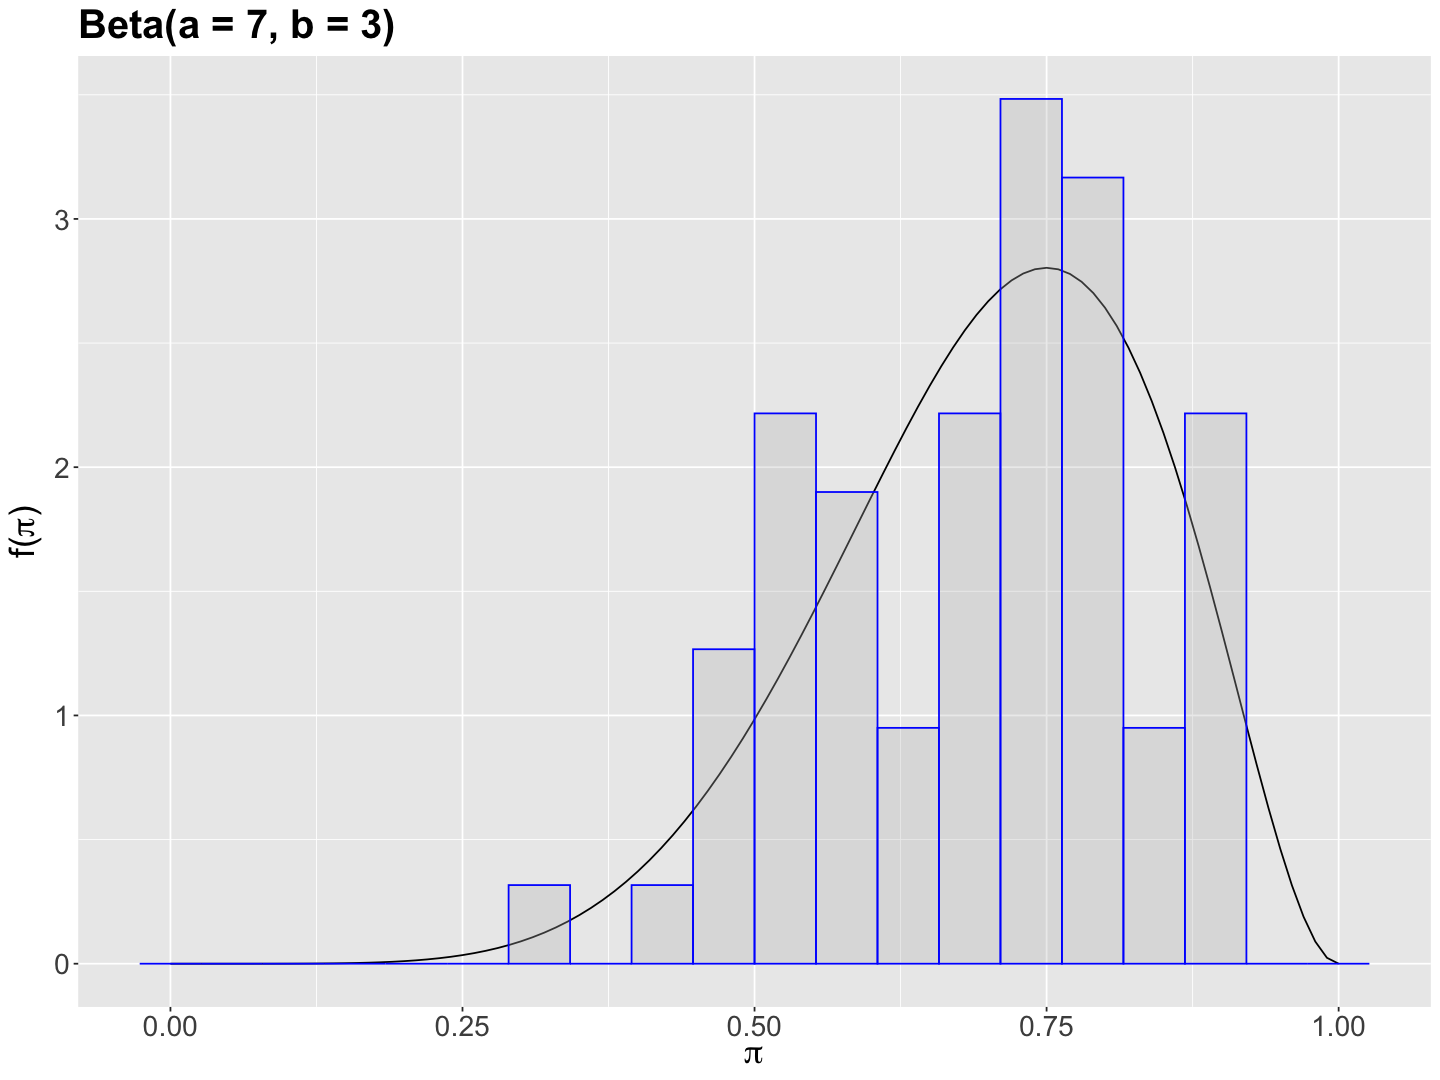

In [5]:
beta_7_3

```{caution}
In [*3.1.2 Tuning the Beta prior*](https://www.bayesrulesbook.com/chapter-3.html#the-binomial-data-model-likelihood-function), the textbook suggests tuning the Beta hyperparameters versus our prior data on a *trial and error* process. Nonetheless, we might **avoid** this **empirical** approach by running a [**goodness of fit test**](https://onlinelibrary.wiley.com/doi/full/10.1002/sta4.341) in our prior data. This class of test is used to verify whether your data comes from a specific population of interest (such as the Beta under specific hyperparameters of interest).
```

```{attention}
**Unless stated otherwise**, most of the exercises in this course will provide the specific hyperparameters to be used in our prior model. **One of the main matters in this block will be choosing the right random variables** (e.g., Normal, Gamma, Beta, etc.).
```

We can plug in $a = 7$ and $b = 3$ into the **theoretical Beta mean, variance, mode, and standard deviation**. The `bayesrules` package has the handy function `summarize_beta_binomial()`.

In [6]:
summarize_beta_binomial(a = 7, b = 3) |> 
  mutate_if(is.numeric, round, 3)

Warning message in summarize_beta_binomial(a = 7, b = 3):
“To summarize the posterior, 
            specify data y and n”


model,alpha,beta,mean,mode,var,sd
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
prior,7,3,0.7,0.75,0.019,0.138


We contrast this theoretical prior metrics with the ones obtained for `prior_pi_studies`.

In [7]:
round(mean(prior_pi_studies$prior_pi), 3)

[1] 0.689

In [8]:
round(var(prior_pi_studies$prior_pi), 3)


[1] 0.019

In [9]:
round(sd(prior_pi_studies$prior_pi), 3)

[1] 0.137

Both sets of prior metrics are **pretty close**. Hence, we can continue our Bayesian modelling with a **theoretical** prior $\text{Beta}(a = 7, b = 3)$. Note this modelling choice is not unique, but we need to justify it properly (**a goodness of fit test, for instance!**). 

```{important}
This is one of the biggest challenges in Bayesian inference: *choosing the most **informative** priors*.
```

### 3.5. Setting up the Likelihood

We need to obtain **our evidence**, so we can set up our **likelihood**. In our study, assume we run a total of $n = 50$ bottle cap tosses and 70% of them land $\text{right side up}$ (the $\text{success}$).

Using the results from our previous stage, our Bayesian model will be set up as follows:

```{math}
\begin{gather*}
Y \mid \pi \sim \text{Binomial}(n = 50, \pi) \\
\pi \sim \text{Beta}(a = 7, b = 3).
\end{gather*}
```

We already have our **PRIOR** which is a Beta distribution. Thus, our likelihood will come from a Binomial distribution. **How can we plot this likelihood?**

Again, let us check the Shiny app:

1. Go to section [**`Data and likelihood`**](https://shiny-apps.stat.ubc.ca/FlexibleLearning/FirstBayes/Beta-Binomial/#section-data-and-likelihood). 
2. Then, in `Select the data you want to analyze`, select `Custom data`.
3. To customize the likelihood according to **our evidence**, set `n = 50` and $\hat{\pi}$ `= 0.7` (i.e., $\hat{p}$ `= 0.7` in the app). 

Our plotted likelihood function is given by the Binomial PDF:

$$\mathscr{l}(\pi \mid y) = {n \choose y} \pi^y (1 - \pi)^{n - y},$$

where $y$ is the **observed** number of successes in our study.

Note that this function, with $n = 50$, is **maximized** at:

$$\hat{\pi} = \frac{\text{Number of Successes}}{n} = 0.7.$$

### 3.6. The Bayes' Rule in Action 

We already have our Beta **prior** and Binomial **likelihood**. It is time to apply the Bayes' rule as follows:

$$\text{posterior} \propto \text{prior} \times \text{likelihood}$$

$$
\overbrace{f(\pi \mid y)}^{\text{Posterior}} \propto \overbrace{f(\pi)}^{\text{Prior}} \times \overbrace{\mathscr{l}(\pi \mid y)}^{\text{Likelihood}}
$$

$$
\underbrace{f(\pi \mid y)}_{\text{Posterior}} \propto \underbrace{\frac{\Gamma(a + b)}{\Gamma(a) \Gamma(b)} \pi ^{a - 1} (1 - \pi)^{b - 1}}_{\text{Prior}} \times \underbrace{{n \choose y} \pi^y (1 - \pi)^{n - y}}_{\text{Likelihood}}.
$$

**The expression above seems too much!** But, recall we have a trick here: $\propto$. Hence, we can get rid of all the terms that **DO NOT** depend on $\pi$ on the right-hand side (under the Bayes' rule, **they are viewed as part of the normalizing constant!**):

$$
f(\pi \mid y) \propto \pi ^{a - 1} (1 - \pi)^{b - 1} \pi^y (1 - \pi)^{n - y} = \pi ^{(a + y) - 1} (1 - \pi)^{(b + n - y) - 1}.
$$

```{attention}
We are just grouping exponents by common bases in the above equation.
```

This result gives us **an interesting insight for the posterior distribution of $\pi$**:

$$
f(\pi \mid y) \propto \underbrace{\pi ^{(a + y) - 1} (1 - \pi)^{(b + n - y) - 1}}_{\text{Kernel of a Beta}(a + y, b + n - y)}.
$$

This expression is what we call a **kernel** of a $\text{Beta}(a + y, b + n - y)$. 

```{important}
A kernel is the part of a given PDF that **DOES DEPEND** on our parameter of interest! The $\propto$ symbol allows us to conclude this matter.
```

Hence, we just obtained the posterior of $\pi$:

$$f(\pi \mid y) = \overbrace{\frac{\Gamma(a + b + n)}{\Gamma(a + y) \Gamma(b + n - y)}}^{\text{Does not depend on $\pi$}} \pi ^{(a + y) - 1} (1 - \pi)^{(b + n - y) - 1}.$$

Keep in mind that $y$ is **the number of successes** in our study (i.e, $y = 50 \times 0.7 = 35$).

Finally, we can state the posterior probability of $\pi$ as:

$$\pi \mid Y = y \sim \text{Beta}(a + y, b + n - y).$$

Moreover, given this distribution, there will be new **POSTERIOR** metrics:

$$E(\pi \mid Y = y) = \frac{a + y}{a + b + n} \quad \text{and} \quad \text{Var}(\pi \mid Y = y) = \frac{(a + y)(b + n - y)}{(a + b + n)^2(a + b + n + 1)}.$$

The **POSTERIOR** standard deviation is 

$$\text{sd}(\pi \mid Y = y) = \sqrt{\text{Var}(\pi \mid Y = y)}.$$

And the **POSTERIOR** mode is:

$$\text{Mode}(\pi \mid Y = y) = \frac{a + y - 1}{a + b + n - 2}.$$

```{attention}
The **POSTERIOR** mode has a special relevance, and we will find it out when reviewing the graphical results.
```

````{admonition} Optional Material

You might wonder whether the original Bayes' rule {eq}`full-bayes-rule`

$$\text{posterior} = \frac{\text{prior} \times \text{likelihood}}{\text{normalizing constant}}$$

can be used analytically to obtain the extact posterior $f(\pi \mid y)$. In fact, it is possible to do so as follows:

$$
\overbrace{f(\pi \mid y)}^{\text{Posterior}} = \frac{\overbrace{f(\pi)}^{\text{Prior}} \times \overbrace{\mathscr{l}(\pi \mid y)}^{\text{Likelihood}}}{\underbrace{\mathscr{l}(y)}_{\text{Normalizing Constant}}}.
$$

We already know that

$$f(\pi) = \frac{\Gamma(a + b)}{\Gamma(a) \Gamma(b)} \pi^{a - 1} (1 - \pi)^{b - 1}$$

and

$$\mathscr{l}(\pi \mid y) = {n \choose y} \pi^y (1 - \pi)^{n - y}.$$

Thus, we need to obtain the **normalizing constant** that **does not depend on parameter $\pi$**. It turns out this normalizing constant is known as the **marginal likelihood** (since it marginalizes $\pi$ from the joint distribution between the observed successes $y$ and the probability of success $\pi$), which is denoted as $f(y, \pi)$. Note this joint distribution is probabilistically viewed as an **intersection of events**.

Having said all this, let us go back to the Bayes' rule:

```{math}
\begin{align*}
f(\pi \mid y) &= \frac{f(\pi) \times \mathscr{l}(\pi \mid y)}{\mathscr{l}(y)} \\
&= \frac{f(\pi) \times \mathscr{l}(\pi \mid y)}{\int_{\Pi} f(y, \pi) \text{d}\pi} \\
&= \frac{f(\pi) \times \mathscr{l}(\pi \mid y)}{\int^1_0 f(y, \pi) \text{d}\pi}.
\end{align*}
```

Note that solving the above integral for $\pi$ from $0$ to $1$, **that is marginalizing out $\pi$**, results in this normalizing constant. Now, the question arises on how to obtain the joint distribution $f(y, \pi)$. **Since $f(y, \pi)$ is probabilistically an intersection of events**, then we can apply the Bayes' rule in the denominator as follows:

```{math}
:label: posterior-pi
f(\pi \mid y) = \frac{f(\pi) \times \mathscr{l}(\pi \mid y)}{\int^1_0 \underbrace{f(y \mid \pi) \times f(\pi)}_{f(y, \pi)} \text{d}\pi}.
```

Given that the PDF $f(y \mid \pi)$ (which is Binomial) is **mathematically** equal to the likelihood $\mathscr{l}(\pi \mid y)$, we have:

$$f(y \mid \pi) = \mathscr{l}(\pi \mid y) = {n \choose y} \pi^y (1 - \pi)^{n - y}.$$

Moreover, we already know the prior

$$f(\pi) = \frac{\Gamma(a + b)}{\Gamma(a) \Gamma(b)} \pi^{a - 1} (1 - \pi)^{b - 1}.$$

Going back to Equation {eq}`posterior-pi`, we have that:

```{math}
:label: posterior-pi-2
\begin{align*}
f(\pi \mid y) &= \frac{\overbrace{\left[ \frac{\Gamma(a + b)}{\Gamma(a) \Gamma(b)} \pi^{a - 1} (1 - \pi)^{b - 1} \right]}^{f(\pi)} \times \overbrace{\left[ {n \choose y} \pi^y (1 - \pi)^{n - y} \right]}^{\mathscr{l}(\pi \mid y)}}{\int^1_0 \underbrace{\left[ {n \choose y} \pi^y (1 - \pi)^{n - y} \right]}_{f(y \mid \pi)} \times \underbrace{\left[ \frac{\Gamma(a + b)}{\Gamma(a) \Gamma(b)} \pi^{a - 1} (1 - \pi)^{b - 1} \right]}_{f(\pi)} \text{d}\pi} \\
&= \frac{\frac{\Gamma(a + b)}{\Gamma(a) \Gamma(b)} {n \choose y} \pi^{a - 1} (1 - \pi)^{b - 1} \pi^y (1 - \pi)^{n - y}}{\frac{\Gamma(a + b)}{\Gamma(a) \Gamma(b)} {n \choose y} \int^1_0 \pi^y (1 - \pi)^{n - y} \pi^{a - 1} (1 - \pi)^{b - 1} \text{d}\pi} \quad \text{rearranging terms that do not depend on } \pi \\
&= \frac{\pi^{a - 1} (1 - \pi)^{b - 1} \pi^y (1 - \pi)^{n - y}}{\int^1_0 \pi^y (1 - \pi)^{n - y} \pi^{a - 1} (1 - \pi)^{b - 1} \text{d}\pi} \quad \text{cancelling out terms that do not depend on } \pi \\
&= \frac{\pi ^{(a + y) - 1} (1 - \pi)^{(b + n - y) - 1}}{\int^1_0 \pi ^{(a + y) - 1} (1 - \pi)^{(b + n - y) - 1} \text{d}\pi} \quad \text{grouping exponents by common bases.}
\end{align*}
```

**How do we solve the above integral in the denominator?** From the [**Beta PDF in the cheatsheet**](beta-distribution) and the [**basic distributional probability concepts**](basic-distributional-concepts), we know that that the Beta PDF (on the range of the corresponding random variable) has to integrate to $1$. **Therefore, we can use the following workaround:**

```{math}
\begin{gather*}
\int^1_0 \left\{ \frac{\Gamma\left[ (a + y) + (b + n - y) \right]}{\Gamma(a + y) \Gamma(b + n - y)} \pi ^{(a + y) - 1} (1 - \pi)^{(b + n - y) - 1} \right\} \text{d}\pi = 1 \\
\frac{\Gamma\left[ (a + y) + (b + n - y) \right]}{\Gamma(a + y) \Gamma(b + n - y)} \int^1_0 \pi ^{(a + y) - 1} (1 - \pi)^{(b + n - y) - 1} \text{d}\pi = 1 \\
\int^1_0 \pi ^{(a + y) - 1} (1 - \pi)^{(b + n - y) - 1} \text{d}\pi = \frac{\Gamma(a + y) \Gamma(b + n - y)}{\Gamma\left[ (a + y) + (b + n - y) \right]}.
\end{gather*}
```

Then, we can go back to Equation {eq}`posterior-pi-2`:

```{math}
\begin{align*}
f(\pi \mid y) &= \frac{\pi ^{(a + y) - 1} (1 - \pi)^{(b + n - y) - 1}}{\frac{\Gamma(a + y) \Gamma(b + n - y)}{\Gamma\left[ (a + y) + (b + n - y) \right]}} \\
&= \frac{\Gamma\left[ (a + y) + (b + n - y) \right]}{\Gamma(a + y) \Gamma(b + n - y)} \pi ^{(a + y) - 1} (1 - \pi)^{(b + n - y) - 1} \\
&= \frac{\Gamma(a + b + n)}{\Gamma(a + y) \Gamma(b + n - y)} \pi ^{(a + y) - 1} (1 - \pi)^{(b + n - y) - 1}.
\end{align*}
```

We end up with the exact posterior of $\pi$ which is an updated $\text{Beta}(a + y, b + n - y)$:

$$f(\pi \mid y) = \frac{\Gamma(a + b + n)}{\Gamma(a + y) \Gamma(b + n - y)} \pi ^{(a + y) - 1} (1 - \pi)^{(b + n - y) - 1}.$$

Then:

$$\pi \mid Y = y \sim \text{Beta}(a + y, b + n - y).$$

**Note this class of proof is out of the scope of this course.**
````

## 4. Posterior Analysis

Now, let us go back to the Shiny app:

1. Click on section [**`Posterior analysis`**](https://shiny-apps.stat.ubc.ca/FlexibleLearning/FirstBayes/Beta-Binomial/#section-posterior-analysis). 
2. You will find the corresponding posterior PDF of $\pi$ (i.e., $p$ in the app) along with posterior metrics of interest.

We can also obtain posterior metrics via `summarize_beta_binomial()`.

In [10]:
summarize_beta_binomial(a = 7, b = 3, y = 35, n = 50) |> 
  mutate_if(is.numeric, round, 3)

model,alpha,beta,mean,mode,var,sd
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
prior,7,3,0.7,0.750,0.019,0.138
posterior,42,18,0.7,0.707,0.003,0.059


```{admonition} What happened here?
:class: warning
We just updated our beliefs on $\pi$ with our evidence (likelihood) and prior knowledge. These beliefs are reflected in the Beta posterior. Note the prior and posterior means are practically equal, but the posterior spread is smaller! **Our posterior results show a reduced uncertainty on the estimation of $\pi$.**
```

Now, let us formally define a new Bayesian concept: the **quantile-based credible interval**.

```{admonition} Formal Definition of the Posterior Quantile-based Credible Interval
:class: important
The quantile-based credible interval (CI) is a range of **posterior plausible values** for our population parameter of interest. Its width will provide an insight into the variability in our Bayesian posterior distribution. Moreover, it is an interval metric of central tendency.

Let $\theta$ be your population parameter of interest **IN GENERAL**, along with $Y$ (your evidence, i.e., likelihood). The $k\%$ credible interval is any interval $I = [u, v]$ such that:

$$P(u \leq \theta \leq v | Y) = \frac{k}{100}.$$

**Note the quantile-based credible interval is obtained using the corresponding posterior distribution $f(\theta \mid y)$.** For example, the 95% CI will be the 2.5th and 97.5th posterior percentiles (i.e., the bounds $u$ and $v$ respectively). These percentiles are obtained from $f(\theta \mid y)$.
```

**For this well-behaved theoretical Bayesian model**, we only need the function `qbeta()` to obtain the 95% CI. We already know our posterior distribution:

$$\pi \mid Y = y \sim \text{Beta}(a + y, b + n - y).$$

Since $a = 7$, $b = 3$, $n = 50$, and $y = 35$; then we have:

$$\pi \mid Y = y \sim \text{Beta}(42, 18).$$

The 95% CI is given by:

In [11]:
round(qbeta(p = c(0.025, 0.975), shape1 = 42, shape2 = 18), 2)

[1] 0.58 0.81

How do we interpret this 95% CI? 

> *There is a 95% **POSTERIOR** probability that the success probability $\pi$ is between 0.58 and 0.81.*

```{attention}
Recall we already clarified this inferential case is a **probability distribution over probabilities**. For other cases, "the success probability $\pi$" is replaced by "a population continuous mean $\mu$", "a population count mean $\lambda$", "a population regression slope $\beta_1$", etc.
```

Again, let us check the Shiny app in the section [**`Summary`**](https://shiny-apps.stat.ubc.ca/FlexibleLearning/FirstBayes/Beta-Binomial/#section-summary). We will find the three plots associated with our prior, likelihood and posterior. **Note how the posterior distribution has a smaller spread when compared to the prior.**

We can also use the function `plot_beta_binomial()` from `bayesrules`:

In [12]:
beta_binomial_plots <- plot_beta_binomial(a = 7, b = 3, y = 35, n = 50) +
  labs(x = expression(paste(pi))) +
  ggtitle("Comparison of Prior, Likelihood, and Posterior") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    legend.text = element_text(size = 21, margin = margin(r = 1, unit = "cm")),
  )

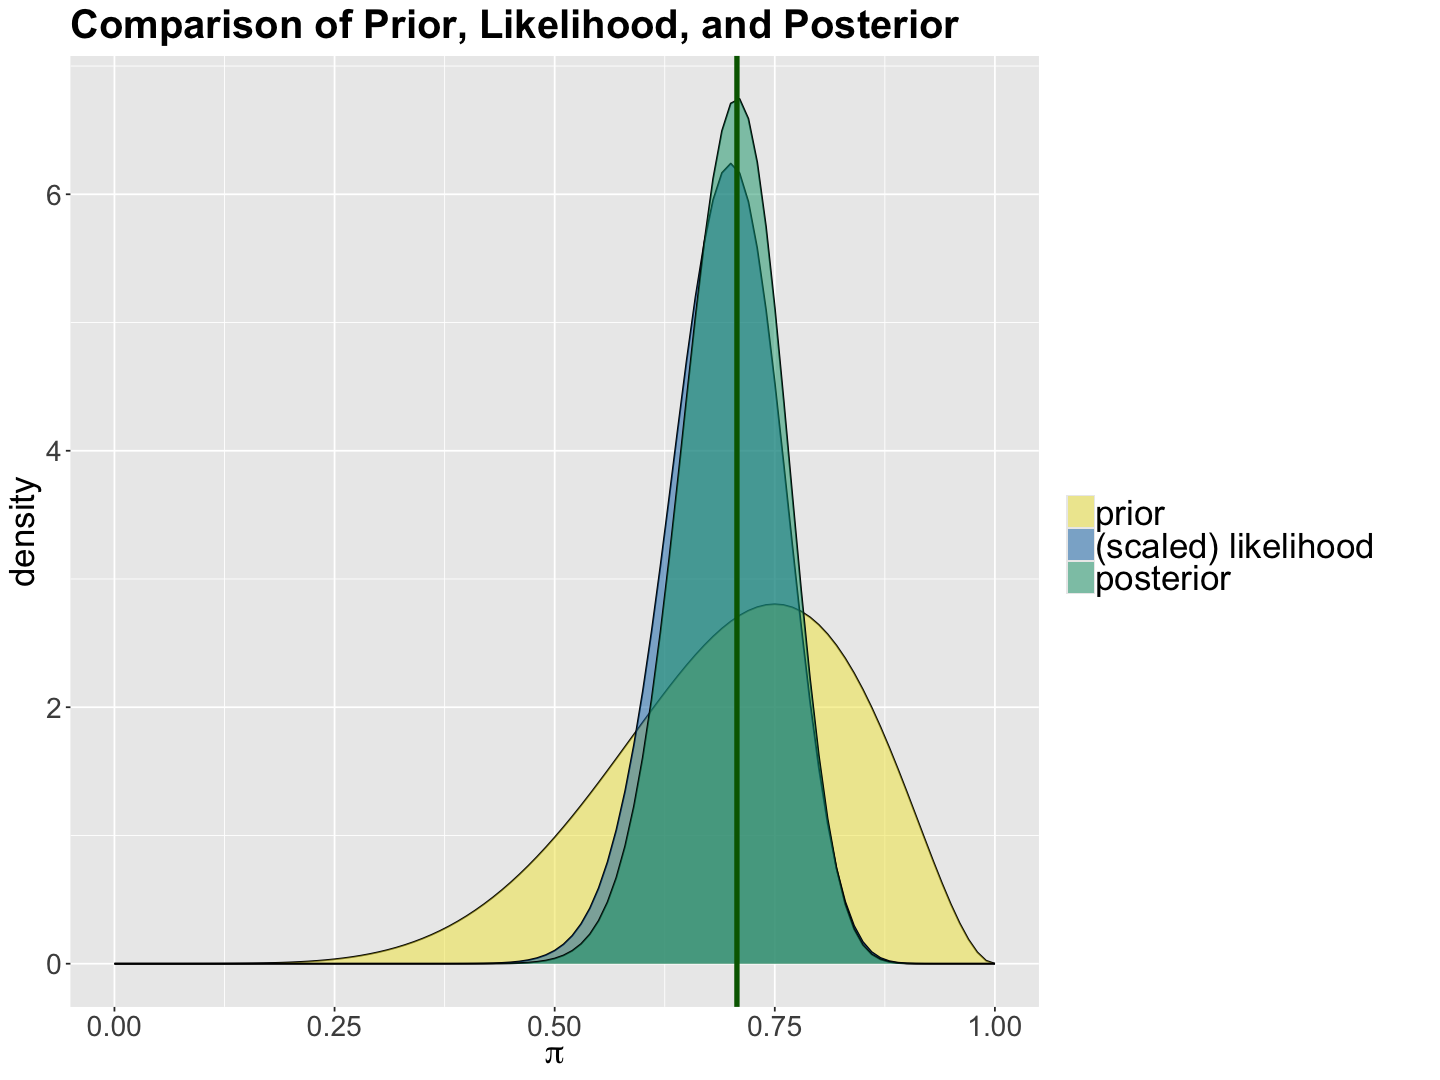

In [13]:
beta_binomial_plots + geom_vline(aes(xintercept = 0.707), colour = "darkgreen", linewidth = 1.5)

In [14]:
summarize_beta_binomial(a = 7, b = 3, y = 35, n = 50) |> 
  mutate_if(is.numeric, round, 3)

model,alpha,beta,mean,mode,var,sd
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
prior,7,3,0.7,0.750,0.019,0.138
posterior,42,18,0.7,0.707,0.003,0.059


```{exercise}
:label: lecture3-q5

Given your results in the plots and summary, what is the big picture regarding the posterior inference on $\pi$? What is the intuition behind the **POSTERIOR MODE**?
```

## 5. Wrapping Up

- The Beta-Binomial model is a foundational Bayesian model to infer a population probability of success $\pi$. There are another foundational Bayesian models such as the [Gamma-Poisson](https://www.bayesrulesbook.com/chapter-5.html#gamma-poisson-conjugate-family) and [Normal-Normal](https://www.bayesrulesbook.com/chapter-5.html#normal-normal-conjugate-family).
- The Beta distribution is a suitable prior distribution for a probability.
- When applying the Bayes' rule with a Binomial likelihood, we obtain an updated posterior Beta for $\pi$. **When the prior is from the same family as the posterior, we call it a CONJUGATE PRIOR.**
- What would happen to the posterior if we change the hyperparameters of our Beta prior? What if we reduce the amount of evidence (i.e., smaller values for $n$ and $y$ in the likelihood)? We will explore these matters in `lab2`.